In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import re
import string,time
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')
from nltk import sentiment
#from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
###Data Extraction
!tar -xvf '/content/drive/MyDrive/aclImdb_v1.tar'

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [4]:
def read_imdb(data_dir):
    data = []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir,label)
        for file in os.listdir(folder_name):
          #print(file)
          with open(os.path.join(folder_name, file), 'rb') as f:
            #print(f.name.split('/')[5].split('.')[0])
            fname = f.name.split('/')[5].split('.')[0].split('_')
            review = f.read().decode('utf-8').replace('\n', '')
            sentiment = 1 if label == 'pos' else -1

            data_tuple = (fname[0],fname[1],sentiment,review)
            data.append(data_tuple)
            #break
    return data 

def generate_csv(data,filename):
  np.savetxt(filename, [p for p in zip(data[0], data[1], data[2],data[3])], delimiter='|', fmt='%s')

TRAIN_PATH='/content/aclImdb/train/'
TEST_PATH='/content/aclImdb/test/'

train = read_imdb(TRAIN_PATH)
test = read_imdb(TEST_PATH)


In [5]:
df_train = pd.DataFrame(train, columns =['movie_id','rating','label','review'])
df_test = pd.DataFrame(test, columns =['movie_id','rating','label','review'])

df_train.head(6)



,movie_id,rating,label,review
0,9055,10,1,This is an amazing movie and all of the actors...
1,11344,7,1,Pufnstuf is what it is. I saw this in the cine...
2,362,10,1,In the year 1985 (my birth year) Steven Spielb...
3,6566,8,1,Ever wonder where the ideas for romance novels...
4,5777,8,1,"A meteor crashes into Crater Lake, the heat fr..."
5,2784,8,1,Nagra comes from conservative Indian family th...


In [6]:
frames= [df_train,df_test]
df = pd.concat(frames,ignore_index=True)
print(df.shape)
df.tail(6)

(50000, 4)


,movie_id,rating,label,review
49994,10937,1,-1,Did Uwe Boll seriously just rip off the basic ...
49995,11636,3,-1,"This movie didn't do it for me, an avid SNL fa..."
49996,4029,1,-1,This is such a crappy movie I have no idea how...
49997,6397,4,-1,"All in all, don't expect much and you won't be..."
49998,3194,1,-1,This was really the worst movie I've ever seen...
49999,2950,4,-1,1st watched 2/18/2007 - 4 out of 10(Dir-Leon L...


In [7]:
df = df.drop('movie_id', 1)

In [8]:
df = df.drop('rating', 1)

In [9]:
df = df[["review","label"]]

In [10]:
print(df.shape)
df.tail(6)

(50000, 2)


,review,label
49994,Did Uwe Boll seriously just rip off the basic ...,-1
49995,"This movie didn't do it for me, an avid SNL fa...",-1
49996,This is such a crappy movie I have no idea how...,-1
49997,"All in all, don't expect much and you won't be...",-1
49998,This was really the worst movie I've ever seen...,-1
49999,1st watched 2/18/2007 - 4 out of 10(Dir-Leon L...,-1


In [19]:
TMR_PATH = '/content/IMDb_TSR_Reviews.csv' 

tsr_data = pd.read_csv(TMR_PATH, usecols = ['Reviews','Scores'])
tsr_data. rename(columns = {'Reviews':'review', 'Scores':'rating'}, inplace = True)
tsr_data.head()

,review,rating
0,Why do I want to write the 234th comment on Th...,10.0
1,The Shawshank Redemption is written and direct...,10.0
2,"In its Oscar year, Shawshank Redemption (writt...",10.0
3,This movie is not your ordinary Hollywood flic...,10.0
4,I'm trying to save you money; this is the last...,10.0


In [20]:
tsr_data.isna().sum()

review      0
rating    564
dtype: int64

In [21]:
tsr_data = tsr_data[tsr_data['rating'].notna()]
print("Shape after filtering out NA ratings",tsr_data.shape)

Shape after filtering out NA ratings (9522, 2)


In [22]:
tsr_data['rating'] = tsr_data['rating'].astype(int)
tsr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9522 entries, 0 to 10085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9522 non-null   object
 1   rating  9522 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 223.2+ KB


In [23]:
ratings = tsr_data.rating.unique()
print("Rating values : ",np.sort(ratings))
print("Len ( Rating ) : ",len(ratings))

Rating values :  [ 1  2  3  4  5  6  7  8  9 10]
Len ( Rating ) :  10


In [24]:
print(tsr_data["rating"].value_counts())

10    6574
9     1601
8      579
7      251
6      147
1      146
5      110
4       54
3       35
2       25
Name: rating, dtype: int64


In [25]:
def generate_label(score):
    if score > 6 :
      return 'positive' #1
    elif score > 4 :
      return 'neutral' #0
    else : 
      return 'negative' #-1
    
#Assigning label to the dataset
tsr_data['label'] = tsr_data.apply(lambda x: generate_label(x['rating']), axis=1)
tsr_data.head(5)

,review,rating,label
0,Why do I want to write the 234th comment on Th...,10,positive
1,The Shawshank Redemption is written and direct...,10,positive
2,"In its Oscar year, Shawshank Redemption (writt...",10,positive
3,This movie is not your ordinary Hollywood flic...,10,positive
4,I'm trying to save you money; this is the last...,10,positive


In [26]:
print(tsr_data["label"].value_counts())

positive    9005
negative     260
neutral      257
Name: label, dtype: int64


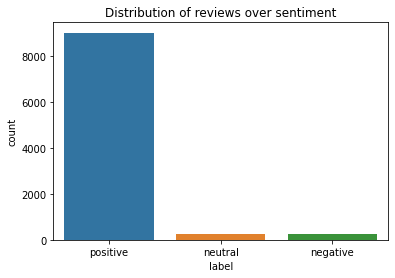

In [27]:
sns.countplot(tsr_data['label'], data=tsr_data)
plt.title("Distribution of reviews over sentiment")
plt.show()

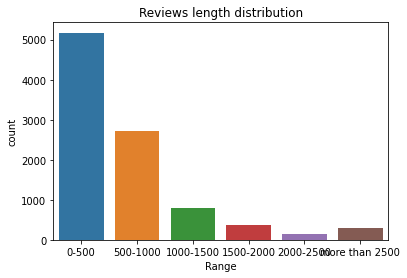

In [28]:
def calc_len(x):
  #print(len(x))
  return len(x)

tsr_data['wordcount'] = tsr_data['review'].apply(calc_len)
#tsr_data.head(5)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
tsr_data['bins'] = pd.cut(tsr_data['wordcount'], bins=bins, labels=labels)

sns.countplot(tsr_data['bins'], data=tsr_data)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

In [29]:
tsr_data_wc=tsr_data.groupby(['bins','label']).size()
print (tsr_data_wc)

bins            label   
0-500           negative     155
                neutral      137
                positive    4881
500-1000        negative      55
                neutral       69
                positive    2602
1000-1500       negative      21
                neutral       28
                positive     744
1500-2000       negative      16
                neutral       10
                positive     349
2000-2500       negative       8
                neutral        8
                positive     138
more than 2500  negative       5
                neutral        5
                positive     291
dtype: int64


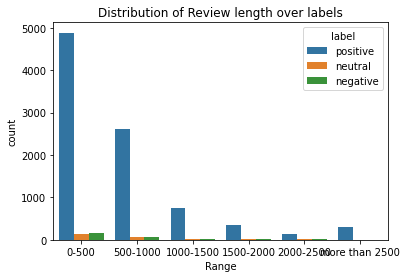

In [30]:
sns.countplot(x='bins', hue='label', data=tsr_data)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

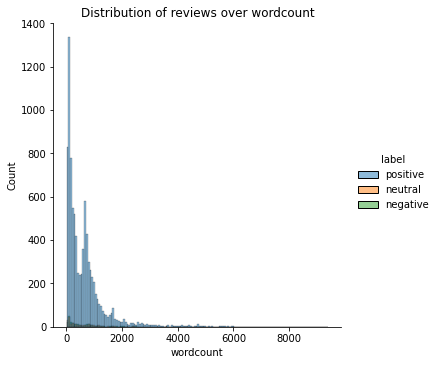

In [31]:
sns.displot(x= 'wordcount', hue = 'label', data = tsr_data)
plt.title('Distribution of reviews over wordcount')
plt.show()

#Most of the negative reviews are generally shorter

In [32]:
def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords]
    
    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [33]:
tsr_data['label'] = tsr_data['label'].map({'positive': 1, 'negative': -1, 'neutral':0})
tsr_data.head(4)

,review,rating,label,wordcount,bins
0,Why do I want to write the 234th comment on Th...,10,1,1693,1500-2000
1,The Shawshank Redemption is written and direct...,10,1,3629,more than 2500
2,"In its Oscar year, Shawshank Redemption (writt...",10,1,4751,more than 2500
3,This movie is not your ordinary Hollywood flic...,10,1,1659,1500-2000


In [34]:
df1 = tsr_data[(tsr_data['label'] != 0) ]
df_X =  df1['review'].apply(clean_data)
df_Y = df1['label']
print("Total length",len(df1))
print("Positive Reviews",len(df1[(df1['label']==1) ]))
print("Negative Reviews",len(df1[(df1['label']==-1) ]))
print(df_X.shape, df_Y.shape)

Total length 9265
Positive Reviews 9005
Negative Reviews 260
(9265,) (9265,)


In [35]:
df1 = df1.drop('wordcount', 1)

In [36]:
df1 = df1.drop('rating', 1)


In [37]:
df1 = df1.drop('bins', 1)

In [38]:
df1 = df1[["review","label"]]

In [39]:
df1[(df1['label']==-1) ].head(5)

,review,label
70,This movie is a total piece of manipulation. I...,-1
87,"!!Spoilers to this movie, as well as to Sixth ...",-1
107,"Last week, I had seen ""The Lord of the Rings: ...",-1
115,Watching this film made me think about the gen...,-1
135,"Stephen King is of course, a gifted storytelle...",-1


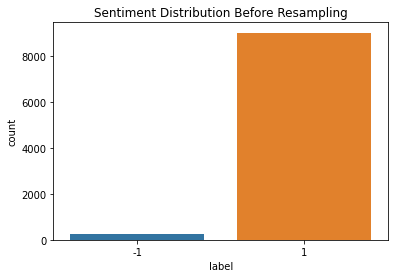

Positive initial 260
Positive upsample 9005


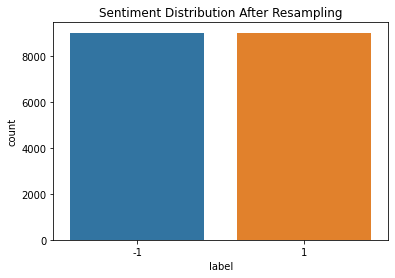

Total Reviews 18010


In [40]:
sns.countplot('label', data=df1).set_title('Sentiment Distribution Before Resampling')
plt.show()

X_no = df1[df1.label == 1]
X_yes = df1[df1.label == -1]
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)
print("Positive initial",len(X_yes))
print("Positive upsample",len(X_yes_upsampled))

df1 = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('label', data=df1).set_title('Sentiment Distribution After Resampling')
plt.show()

print("Total Reviews", len(df1))

In [41]:
df1.shape

(18010, 2)

In [42]:
df1=df1[["review","label"]]

In [43]:
df1.tail()

,review,label
18005,This film concept does not attract me. The plo...,-1
18006,"It deserve 8-9 stars in my opinion, but no way...",-1
18007,Shawshank is on TNT approximately five million...,-1
18008,I'm sorry I don't mean to offend people who li...,-1
18009,"Shawshank Redemption is a story of, well, Rede...",-1


In [44]:
df.columns = ['TEXT_COLUMN_NAME','LABEL_COLUMN_NAME']


In [45]:
df1.columns = ['TEXT_COLUMN_NAME','LABEL_COLUMN_NAME']

In [46]:
import spacy
spacy.load('en_core_web_sm')

In [47]:
import torchtext
import random

In [48]:
# general Settings

RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

In [49]:
TEXT = torchtext.legacy.data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm')

In [50]:
# Define Label processing

LABEL = torchtext.legacy.data.LabelField(dtype = torch.long)

In [51]:
df.to_csv('moviedata.csv', index = None)
df = pd.read_csv('moviedata.csv')
df.head()

,TEXT_COLUMN_NAME,LABEL_COLUMN_NAME
0,This is an amazing movie and all of the actors...,1
1,Pufnstuf is what it is. I saw this in the cine...,1
2,In the year 1985 (my birth year) Steven Spielb...,1
3,Ever wonder where the ideas for romance novels...,1
4,"A meteor crashes into Crater Lake, the heat fr...",1


In [52]:
df1.to_csv('TSR_moviedata.csv', index = None)
df1 = pd.read_csv('TSR_moviedata.csv')
df1.head()

,TEXT_COLUMN_NAME,LABEL_COLUMN_NAME
0,Why do I want to write the 234th comment on Th...,1
1,The Shawshank Redemption is written and direct...,1
2,"In its Oscar year, Shawshank Redemption (writt...",1
3,This movie is not your ordinary Hollywood flic...,1
4,I'm trying to save you money; this is the last...,1


In [53]:
fields = [('TEXT_COLUMN_NAME', TEXT),('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
                    path = 'moviedata.csv',
                    format = 'csv',
                    skip_header = True,
                    fields = fields
)
TSR_DATA=torchtext.legacy.data.TabularDataset(
                    path = 'TSR_moviedata.csv',
                    format = 'csv',
                    skip_header = True,
                    fields = fields
)

In [54]:
# Split dataset into train and test set

train_data, test_data = dataset.split(split_ratio = [0.8, 0.2], random_state = random.seed(RANDOM_SEED))
TSR_test= TSR_DATA

print('Length of train data', len(train_data))
print('Length of test data', len(test_data))
print('Length of TSR test data', len(TSR_test))

Length of train data 40000
Length of test data 10000
Length of TSR test data 18010


In [55]:
train_data, val_data = train_data.split(split_ratio = [0.85, 0.15], random_state = random.seed(RANDOM_SEED))

print('Length of train data', len(train_data))
print('Length of valid data', len(val_data))

Length of train data 34000
Length of valid data 6000


In [56]:
print(vars(train_data.examples[2000]))

{'TEXT_COLUMN_NAME': ['I', 'just', 'got', 'home', 'from', 'seeing', '"', 'Radio', '.', '"', 'I', "'ve", 'not', 'seen', 'such', 'an', 'inspiring', 'story', 'in', 'a', 'long', 'time', '.', 'My', 'kids', 'are', 'ages', '8', 'and', '5', 'and', 'I', 'would', 'like', 'to', 'take', 'them', 'so', 'that', 'they', 'may', '"', 'feel', '"', 'the', 'message', 'as', 'I', 'did', '-', 'you', 'should', 'seek', 'to', 'find', 'the', 'best', 'in', 'people', 'and', 'love', 'them', 'for', 'who', 'they', 'are', ',', 'not', 'judge', 'them', 'for', 'their', 'differences', '.', 'Cuba', 'Gooding', ',', 'Jr.', 'and', 'Ed', 'Harris', 'both', 'deserve', 'Academy', 'Awards', 'for', 'this', 'movie', '.', 'I', 'do', "n't", 'know', 'why', 'we', 'ca', "n't", 'have', 'more', 'movies', 'like', 'this', ',', 'rather', 'than', 'the', 'junk', 'that', 'is', 'served', 'up', 'at', 'theatres', 'on', 'a', 'daily', 'basis', '.'], 'LABEL_COLUMN_NAME': '1'}


In [57]:
# Build Vocabulary

TEXT.build_vocab(train_data, max_size = VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'vocabulary size: {len(TEXT.vocab)}')
print(f'Label Size: {len(LABEL.vocab)}')

vocabulary size: 20002
Label Size: 2


In [58]:
print(TEXT.vocab.freqs.most_common(30))

[('the', 392097), (',', 372397), ('.', 319315), ('and', 211314), ('a', 211306), ('of', 195099), ('to', 180784), ('is', 146554), ('in', 118906), ('I', 106377), ('it', 103767), ('that', 94210), ('"', 87067), ("'s", 83287), ('this', 82227), ('-', 71141), ('/><br', 68701), ('was', 67417), ('as', 58085), ('with', 58031), ('movie', 57947), ('for', 56393), ('film', 52571), ('The', 51227), ('but', 47109), ('on', 44650), ('(', 44504), ("n't", 44490), (')', 44389), ('you', 42150)]


In [59]:
# Token corresponding to first 10 Indices

print(TEXT.vocab.itos[:20]) #itos = Integer to string

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'I', 'it', 'that', '"', "'s", 'this', '-', '/><br', 'was']


In [60]:
print(TEXT.vocab.stoi['top'])

380


In [61]:
# class labels to Integer from string

print(LABEL.vocab.stoi)

defaultdict(None, {'-1': 0, '1': 1})


In [62]:
LABEL.vocab.freqs

Counter({'-1': 17070, '1': 16930})

In [63]:
# Define Dataloader

train_loader, valid_loader, test_loader, TSR_test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, val_data, test_data,TSR_test),
        batch_size = BATCH_SIZE,
        sort_within_batch = False,
        sort_key = lambda x : len(x.TEXT_COLUMN_NAME),
        #device = DEVICE
    )

In [64]:
# Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
  
print('\nTSR Test:')
for batch in TSR_test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([1145, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([56, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([51, 128])
Target vector size: torch.Size([128])

TSR Test:
Text matrix size: torch.Size([8, 128])
Target vector size: torch.Size([128])


In [65]:
train_loader, valid_loader, test_loader,TSR_test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, val_data, test_data,TSR_test),
        batch_size = BATCH_SIZE,
        sort_within_batch = False,
        sort_key = lambda x : len(x.TEXT_COLUMN_NAME),
        device = DEVICE
    )

In [66]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

In [67]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [68]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [69]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.TEXT_COLUMN_NAME.to(DEVICE)
        labels = batch_data.LABEL_COLUMN_NAME.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')
print(f'TSR Test accuracy: {compute_accuracy(model, TSR_test_loader, DEVICE):.2f}%')

Epoch: 001/020 | Batch 000/266 | Loss: 0.6955
Epoch: 001/020 | Batch 050/266 | Loss: 0.6948
Epoch: 001/020 | Batch 100/266 | Loss: 0.6949
Epoch: 001/020 | Batch 150/266 | Loss: 0.6921
Epoch: 001/020 | Batch 200/266 | Loss: 0.6950
Epoch: 001/020 | Batch 250/266 | Loss: 0.6893
training accuracy: 49.81%
valid accuracy: 51.60%
Time elapsed: 1.01 min
Epoch: 002/020 | Batch 000/266 | Loss: 0.6955
Epoch: 002/020 | Batch 050/266 | Loss: 0.6927
Epoch: 002/020 | Batch 100/266 | Loss: 0.6899
Epoch: 002/020 | Batch 150/266 | Loss: 0.7001
Epoch: 002/020 | Batch 200/266 | Loss: 0.6939
Epoch: 002/020 | Batch 250/266 | Loss: 0.6921
training accuracy: 49.82%
valid accuracy: 51.62%
Time elapsed: 2.00 min
Epoch: 003/020 | Batch 000/266 | Loss: 0.6930
Epoch: 003/020 | Batch 050/266 | Loss: 0.6912
Epoch: 003/020 | Batch 100/266 | Loss: 0.6891
Epoch: 003/020 | Batch 150/266 | Loss: 0.6924
Epoch: 003/020 | Batch 200/266 | Loss: 0.6906
Epoch: 003/020 | Batch 250/266 | Loss: 0.6888
training accuracy: 50.44%
va

In [70]:
import spacy


nlp = spacy.blank("en")

def predict_sentiment(model, sentence):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][1].item()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")

Probability positive:


0.9919500350952148

In [71]:
print('Probability positive:')
predict_sentiment(model, "I really hate this movie. It is really bad and sucks!")

Probability positive:


0.00014126878522802144